In order to simplify the process of analysing the plug-sliding door, the group created a 2D model representing it. That model was constructed using two rectangles, each with a specific material associated to it. In this representation of the door, the group was able to apply constrains to the whole extent of its top part (the top line) and to one of its inferior vertices (the one on the right), simulating the constrains applied in a real situation.

This first section of code was first developed as a way of creating a mesh in julia using gmsh. 
I was then expanded to, using the previous mesh, simulate the load of a force dependant on (x,y), calculating therefore the value of the deformation “u”, having in account that, in this case, there is no distinction between the properties of the two different materials

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 16 (Line)
Info    : Done meshing 1D (Wall 0.000998259s, CPU 0s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 19 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 20 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00598288s, CPU 0.015625s)
Info    : 272 nodes 600 elements


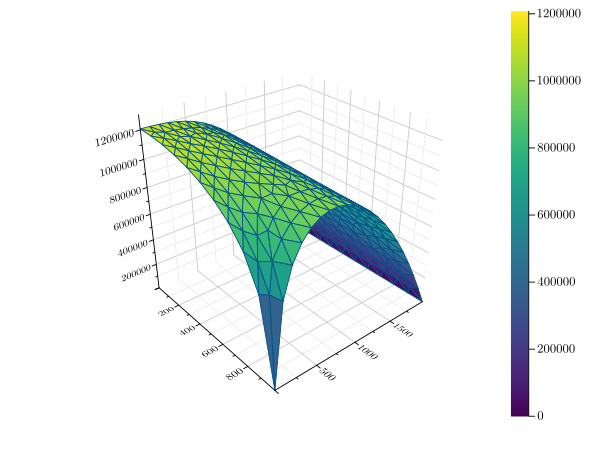

In [70]:
#simple code for mesh with boundary contitions
#dont forget to put your own directories
include("D:/gmsh-4.11.1-Windows64-sdk/gmsh-4.11.1-Windows64-sdk/lib/gmsh.jl")

push!(LOAD_PATH, "D:/gmsh-4.11.1-Windows64-sdk/gmsh-4.11.1-Windows64-sdk/lib")

import Gmsh: gmsh 
using GR 
using LinearAlgebra
using Plots
using LaTeXStrings

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("t1")

lc = 100
 
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1000, 0, 0, lc, 2)
gmsh.model.geo.addPoint(1000, 2000, 0, lc, 3)
gmsh.model.geo.addPoint(0, 2000, 0, lc, 4)
gmsh.model.geo.addPoint(100, 150, 0, lc, 5)
gmsh.model.geo.addPoint(100, 1850, 0, lc, 8)
gmsh.model.geo.addPoint(900, 1850, 0, lc, 7)
gmsh.model.geo.addPoint(900, 150, 0, lc, 6)

gmsh.model.geo.addLine(1, 2, 9)
gmsh.model.geo.addLine(2, 3, 10)
gmsh.model.geo.addLine(3, 4, 11)
gmsh.model.geo.addLine(4, 1, 12)

gmsh.model.geo.addLine(5, 6, 13)
gmsh.model.geo.addLine(6, 7, 14)
gmsh.model.geo.addLine(7, 8, 15)
gmsh.model.geo.addLine(8, 5, 16)

gmsh.model.geo.addCurveLoop([9,10,11,12], 17)
gmsh.model.geo.addCurveLoop([13,14,15,16], 18)

gmsh.model.geo.addPlaneSurface([17,-18], 19)
gmsh.model.geo.addPlaneSurface([18], 20)

gmsh.model.geo.synchronize()

gmsh.model.mesh.generate(2)
if (false) gmsh.write("t1.msh") end 


nodes, coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(nodes)

tosort = [nodes coord[1:3:end] coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

z = ones(length(xnode))
trisurf(xnode,ynode,z)


if (false) gmsh.fltk.run() end 

element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])


func(x,y) = 1
fvalues = map(func, xnode, ynode)


K = zeros(nnodes,nnodes)
f = zeros(nnodes,1)


for element_id in 1:nelements


    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]
  
  
    xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
    ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];
  
    
    x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
    y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
    area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2
  
   
    if (false)
      println("on element ", element_id, " node-1 has global number ", node1_id)
      println("on element ", element_id, " node-2 has global number ", node2_id)
      println("on element ", element_id, " node-3 has global number ", node3_id)
      println("on element ", element_id, " area = ", area_id)
      println(" ")
    end
    fe = area_id/3*[fvalues[node1_id]; fvalues[node2_id]; fvalues[node3_id]]
  
    Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
    Emat[3,:] .= 0;
    Ke = area_id*(transpose(Emat)*Emat);
  
    
    for i = 1:3
    I = element_connectivity[1][3*(element_id-1)+i]
      f[I] += fe[i]
      for j = 1:3
        J = element_connectivity[1][3*(element_id-1)+j]
        K[I,J] += Ke[i,j]
      end
    end
  
end


node_2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
line_2, node_coord, _ = gmsh.model.mesh.getNodes(1,11)

clampd_node = union(node_2,node_3,node_4,line_2)
K[clampd_node,:] .= 0;
K[clampd_node,clampd_node] = Diagonal(ones(size(clampd_node)))
f[clampd_node] .= 0;

u = K\f
#@show xnode
#@show ynode
#@show u

trisurf(xnode,ynode,u)


We then developed the code shown before, separating the physical subdomains of tha aluminum and glass, giving both of them diferent properties. A new force function was also added, as a gaussian function that simulates an impact on a certain point of the mesh.

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 16 (Line)
Info    : Done meshing 1D (Wall 0s, CPU 0s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 19 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 20 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00698423s, CPU 0s)
Info    : 272 nodes 600 elements
Info    : Writing 't1.msh'...
Info    : Done writing 't1.msh'


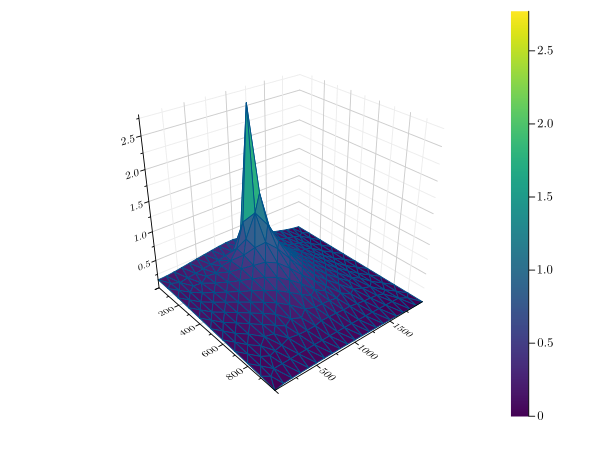

In [71]:
#Mesh wit physical groups and properties


###### dont forget to put your own directories
include("D:/gmsh-4.11.1-Windows64-sdk/gmsh-4.11.1-Windows64-sdk/lib/gmsh.jl") 
push!(LOAD_PATH, "D:/gmsh-4.11.1-Windows64-sdk/gmsh-4.11.1-Windows64-sdk/lib")

import Gmsh: gmsh 
using GR 
using LinearAlgebra
using Plots
using LaTeXStrings

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("t1")


#glass_dens_value=2.5
#alum_dens_value=2.5
#values for mu for aluminum and glass- a higher number represents higher stiffness
mualum=100
muglass=1

#sigma for the gaussian distribution of force
sigma=10
#(x,y) coordenates of center of gaussian load function
mux=200
muy=1000

lc = 100

#mesh generation
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1000, 0, 0, lc, 2)
gmsh.model.geo.addPoint(1000, 2000, 0, lc, 3)
gmsh.model.geo.addPoint(0, 2000, 0, lc, 4)
gmsh.model.geo.addPoint(100, 150, 0, lc, 5)
gmsh.model.geo.addPoint(100, 1850, 0, lc, 8)
gmsh.model.geo.addPoint(900, 1850, 0, lc, 7)
gmsh.model.geo.addPoint(900, 150, 0, lc, 6)

gmsh.model.geo.addLine(1, 2, 9)
gmsh.model.geo.addLine(2, 3, 10)
gmsh.model.geo.addLine(3, 4, 11)
gmsh.model.geo.addLine(4, 1, 12)

gmsh.model.geo.addLine(5, 6, 13)
gmsh.model.geo.addLine(6, 7, 14)
gmsh.model.geo.addLine(7, 8, 15)
gmsh.model.geo.addLine(8, 5, 16)

gmsh.model.geo.addCurveLoop([9,10,11,12], 17)
gmsh.model.geo.addCurveLoop([13,14,15,16], 18)

gmsh.model.geo.addPlaneSurface([17,-18], 19)
gmsh.model.geo.addPlaneSurface([18], 20)

gmsh.model.addPhysicalGroup(2,[19],21)
gmsh.model.addPhysicalGroup(2,[20],22)

gmsh.model.geo.synchronize()

gmsh.model.mesh.generate(2)
if (true) gmsh.write("t1.msh") end 

#sorting of nodes
nodes, coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(nodes)

tosort = [nodes coord[1:3:end] coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]


if (false) gmsh.fltk.run() end 

element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#lists of nodes belonging to each physical subgroup

nalum = gmsh.model.mesh.getNodesForPhysicalGroup(2, 21)
nglass = gmsh.model.mesh.getNodesForPhysicalGroup(2, 22)

e_group = zeros(1,nelements)


K = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#cicle for identifying each elements physical domain
for element_id in 1:nelements

    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]
  
    alumG = sum(node1_id.== nalum[1])+sum(node2_id.== nalum[1])+sum(node3_id.== nalum[1]) 
    glassG = sum(node1_id.== nglass[1])+sum(node2_id.== nglass[1])+sum(node3_id.== nglass[1])
  
    if alumG == 3
        e_group[element_id] = 1;
      elseif glassG == 3
        e_group[element_id] = 2;
    end

    if (false)
        println("on element ", element_id, " e_group[element_id] = ", e_group[element_id])
      end

end


#load function
sourcefunction(x,y) = (1/(2*pi*sigma))*exp(-((x-mux)^2+(y-muy)^2)/(2*sigma^2))
#load function alternative
#(alum_dens_value*(group_id==1)+glass_dens_value*(group_id==2))
#mapping the coordenates of nodes to the load funtion
sourceperelement = map(sourcefunction, xnode, ynode)



reluctivityfunction(group_id) = (mualum)*(group_id==1)+(muglass)*(group_id==2)
reluctivityperelement = map(reluctivityfunction, e_group)

#generation of K and f
    
for element_id in 1:nelements

    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]


    xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
    ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];
  
    
    x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
    y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
    area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2
  
   
    fe = area_id/3*[sourceperelement[node1_id]; sourceperelement[node2_id]; sourceperelement[node3_id]]
    
    #sourceperelement[element_id]*[1; 1; 1]

    
  
    Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
    Emat[3,:] .= 0;
    Ke = area_id*reluctivityperelement[element_id]*(transpose(Emat)*Emat);
  
    
    for i = 1:3
        I = element_connectivity[1][3*(element_id-1)+i]
          f[I] += fe[i]
          for j = 1:3
            J = element_connectivity[1][3*(element_id-1)+j]
            K[I,J] += Ke[i,j]
          end
    end
  
end

#boundary contitions->calmping on the top edge and lower right support

node_2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
line_2, node_coord, _ = gmsh.model.mesh.getNodes(1,11)

clampd_node = union(node_2,node_3,node_4,line_2)
K[clampd_node,:] .= 0;
K[clampd_node,clampd_node] = Diagonal(ones(size(clampd_node)))
f[clampd_node] .= 0;



u = K\f
#@show xnode
#@show ynode
#@show u

trisurf(xnode,ynode,u)



Lastly, an attempt was made to develop the code further and to an linear elasticity model, however, no satisfactury results were reached due to time constraints.